In [154]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm

In [2]:
# do we have a gpu 
gpu = torch.cuda.is_available()

if gpu:
    device = torch.cuda.current_device()
    print(f'GPU device: {device}')
else: 
    print('No GPU')

GPU device: 0


### Data Preparation

In [3]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl")
train_data = train_data.sample(50_000)

validation_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl")
validation_data = validation_data.sample(50_000)

In [4]:
train_keys = [
    "ane",
    "ate",
    "autor",
    "machtor",
    "x",
    "zeff",
    "gammae",
    "q",
    "smag",
    "alpha",
    "ani1",
    "ati0",
    "normni1",
    "ti_te0",
    "lognustar",
]

target_keys = ['target']

In [5]:
x_train, y_train = train_data[train_keys].to_numpy(), train_data[target_keys].to_numpy()

x_val, y_val = validation_data[train_keys].to_numpy(), validation_data[target_keys].to_numpy()

In [6]:
# standard scaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform (x_val)

### Classifier functions

In [197]:
class Classifier(nn.Module):
    def __init__(self, inshape): 
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(inshape, 30), 
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(30, 30), 
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(30,30),
            nn.ReLU(),
            nn.Dropout(p=0.1), 
            nn.Linear(30,30),
            nn.ReLU(),
            nn.Dropout(p = 0.1),
            nn.Linear(30,1)
            #nn.Sigmoid()
        )
        
    def forward(self, x): 
        output = self.model(x)
        
        return output

In [198]:
class ClassifierData(Dataset): 
    def __init__(self, x, y): 
        self.x = x 
        self.y = y
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [199]:
train_set = ClassifierData(x_train, y_train)
valid_set = ClassifierData(x_val, y_val)
train_loader = DataLoader(train_set, batch_size = 1024, shuffle = True)
val_loader = DataLoader(valid_set, batch_size = 1024, shuffle = True)

In [200]:
def train_loop(model, optimiser, epochs, traindata, validdata=None): 
    history = {'epoch_loss': [], 'epoch_val_loss': []}
    
    for epoch in tqdm(range(epochs), desc = 'Epochs'):
        
        running_loss = []
        
        for i, data in enumerate(tqdm(traindata, 0)): 
            x, y = data
            x, y = x.to(device), y.to(device)
            
            
            # zero the parameter gradients
            optimiser.zero_grad()

            #forward + backward + optimize
            y_hat = model(x.float())
            activation = nn.Sigmoid()
            BCE = nn.BCELoss()
            loss = BCE(activation(y_hat.float()), y.float())
            loss.backward()
            optimiser.step()
            
            # print statistics
            running_loss.append(loss.item())
            if i % 1000 == 0:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {np.mean(running_loss) :.6f}')
        
        history['epoch_loss'].append(np.mean(running_loss))
    return history

In [201]:
classifier = Classifier(x_train.shape[1]).to(device)

In [202]:
optimiser = optim.Adam(classifier.parameters(), lr=0.002)

In [203]:
his = train_loop(model=classifier, optimiser=optimiser, epochs=50, traindata=train_loader)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

[1,     1] loss: 0.664071


  0%|          | 0/49 [00:00<?, ?it/s]

[2,     1] loss: 0.582056


  0%|          | 0/49 [00:00<?, ?it/s]

[3,     1] loss: 0.562354


  0%|          | 0/49 [00:00<?, ?it/s]

[4,     1] loss: 0.530045


  0%|          | 0/49 [00:00<?, ?it/s]

[5,     1] loss: 0.528491


  0%|          | 0/49 [00:00<?, ?it/s]

[6,     1] loss: 0.504428


  0%|          | 0/49 [00:00<?, ?it/s]

[7,     1] loss: 0.493109


  0%|          | 0/49 [00:00<?, ?it/s]

[8,     1] loss: 0.509332


  0%|          | 0/49 [00:00<?, ?it/s]

[9,     1] loss: 0.488445


  0%|          | 0/49 [00:00<?, ?it/s]

[10,     1] loss: 0.492542


  0%|          | 0/49 [00:00<?, ?it/s]

[11,     1] loss: 0.463741


  0%|          | 0/49 [00:00<?, ?it/s]

[12,     1] loss: 0.457044


  0%|          | 0/49 [00:00<?, ?it/s]

[13,     1] loss: 0.445040


  0%|          | 0/49 [00:00<?, ?it/s]

[14,     1] loss: 0.453070


  0%|          | 0/49 [00:00<?, ?it/s]

[15,     1] loss: 0.456409


  0%|          | 0/49 [00:00<?, ?it/s]

[16,     1] loss: 0.411423


  0%|          | 0/49 [00:00<?, ?it/s]

[17,     1] loss: 0.458482


  0%|          | 0/49 [00:00<?, ?it/s]

[18,     1] loss: 0.436573


  0%|          | 0/49 [00:00<?, ?it/s]

[19,     1] loss: 0.449764


  0%|          | 0/49 [00:00<?, ?it/s]

[20,     1] loss: 0.422091


  0%|          | 0/49 [00:00<?, ?it/s]

[21,     1] loss: 0.429700


  0%|          | 0/49 [00:00<?, ?it/s]

[22,     1] loss: 0.406514


  0%|          | 0/49 [00:00<?, ?it/s]

[23,     1] loss: 0.430475


  0%|          | 0/49 [00:00<?, ?it/s]

[24,     1] loss: 0.437631


  0%|          | 0/49 [00:00<?, ?it/s]

[25,     1] loss: 0.444884


  0%|          | 0/49 [00:00<?, ?it/s]

[26,     1] loss: 0.399525


  0%|          | 0/49 [00:00<?, ?it/s]

[27,     1] loss: 0.398274


  0%|          | 0/49 [00:00<?, ?it/s]

[28,     1] loss: 0.405088


  0%|          | 0/49 [00:00<?, ?it/s]

[29,     1] loss: 0.403837


  0%|          | 0/49 [00:00<?, ?it/s]

[30,     1] loss: 0.394177


  0%|          | 0/49 [00:00<?, ?it/s]

[31,     1] loss: 0.397941


  0%|          | 0/49 [00:00<?, ?it/s]

[32,     1] loss: 0.410600


  0%|          | 0/49 [00:00<?, ?it/s]

[33,     1] loss: 0.399944


  0%|          | 0/49 [00:00<?, ?it/s]

[34,     1] loss: 0.431869


  0%|          | 0/49 [00:00<?, ?it/s]

[35,     1] loss: 0.414283


  0%|          | 0/49 [00:00<?, ?it/s]

[36,     1] loss: 0.389748


  0%|          | 0/49 [00:00<?, ?it/s]

[37,     1] loss: 0.382002


  0%|          | 0/49 [00:00<?, ?it/s]

[38,     1] loss: 0.422721


  0%|          | 0/49 [00:00<?, ?it/s]

[39,     1] loss: 0.413823


  0%|          | 0/49 [00:00<?, ?it/s]

[40,     1] loss: 0.396240


  0%|          | 0/49 [00:00<?, ?it/s]

[41,     1] loss: 0.401980


  0%|          | 0/49 [00:00<?, ?it/s]

[42,     1] loss: 0.417041


  0%|          | 0/49 [00:00<?, ?it/s]

[43,     1] loss: 0.391300


  0%|          | 0/49 [00:00<?, ?it/s]

[44,     1] loss: 0.403460


  0%|          | 0/49 [00:00<?, ?it/s]

[45,     1] loss: 0.410421


  0%|          | 0/49 [00:00<?, ?it/s]

[46,     1] loss: 0.404106


  0%|          | 0/49 [00:00<?, ?it/s]

[47,     1] loss: 0.393381


  0%|          | 0/49 [00:00<?, ?it/s]

[48,     1] loss: 0.385004


  0%|          | 0/49 [00:00<?, ?it/s]

[49,     1] loss: 0.394946


  0%|          | 0/49 [00:00<?, ?it/s]

[50,     1] loss: 0.360486


In [227]:
t_vals = []

In [228]:
def T_scaling(logits, temperature):
    t_vals.append(temperature.item())
    output = torch.div(logits, temperature)
    activation = nn.Sigmoid()
    return activation(output)

In [229]:
temp = nn.Parameter((1.5*torch.ones(1)).cuda())
criterion = nn.BCELoss()
# optimizer = optim.LBFGS([temp], lr=0.01, max_iter=50, line_search_fn='strong_wolfe')
optimizer = optim.LBFGS([temp], lr=0.01, max_iter=500, line_search_fn='strong_wolfe')
logits_list = []
labels_list = []

for i, data in enumerate(tqdm(val_loader, 0)):
    x, y = data[0].to(device), data[1].to(device)
    
    classifier.eval()
    with torch.no_grad():
        logits_list.append(classifier(x.float()))
        labels_list.append(y.float())

# Create tensors
logits_list = torch.cat(logits_list).to(device)
labels_list = torch.cat(labels_list).to(device)

def _eval():
    loss = criterion(T_scaling(logits_list, temp), labels_list)
    loss.backward()
    return loss

optimizer.step(_eval)

  0%|          | 0/49 [00:00<?, ?it/s]

tensor(0.4056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

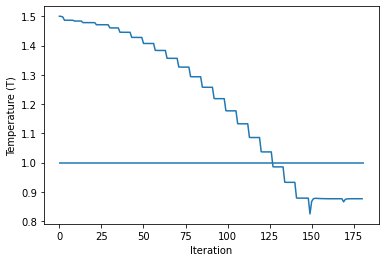

In [230]:
plt.figure()
plt.plot(t_vals)
plt.hlines(1, 0, len(t_vals))
plt.xlabel('Iteration')
plt.ylabel('Temperature (T)');

In [231]:
activation = nn.Sigmoid()

preds = classifier(torch.tensor(x_train).to(device).float()).detach().cpu().numpy()

norm_preds = activation(torch.tensor(preds))
pred_label = np.rint(norm_preds)

df_out = pd.DataFrame(data = y_train, columns = ["true_label"])
df_out["pred_label"] = pred_label
df_out["confidence"] = norm_preds

def f(row):
    if row["pred_label"] == 1:
        confidence = row["confidence"]
    else:
        confidence = 1 - row["confidence"]
        
    return confidence

# for predicted labels 
df_out["new_confidence"] = df_out.apply(lambda x: x["confidence"] if x["pred_label"] == 1 else 1 - x["confidence"], axis = 1)

new_preds = activation(
    torch.div(
        torch.tensor(preds),
        torch.tensor(t_vals[-1])
        )
    )
new_preds = new_preds.numpy()

df_out["temp_scaled"] = new_preds
#df_out[""]
print(t_vals[-1])
#df_out.to_csv(index=False);
df_out

0.8763574957847595


,true_label,pred_label,confidence,new_confidence,temp_scaled
0,1,1.0,0.823594,0.823594,0.852995
1,0,0.0,0.054308,0.945692,0.036956
2,0,1.0,0.735112,0.735112,0.762191
3,0,0.0,0.262606,0.737394,0.235388
4,0,0.0,0.456735,0.543265,0.450668
...,...,...,...,...,...
49995,1,1.0,0.779335,0.779335,0.808427
49996,0,1.0,0.866329,0.866329,0.894028
49997,1,1.0,0.997914,0.997914,0.999126
49998,1,1.0,0.741268,0.741268,0.768716


In [232]:
confusion_matrix(df_out.true_label, df_out.pred_label, normalize = "true")

array([[0.69949167, 0.30050833],
       [0.1216976 , 0.8783024 ]])

/tmp/ipykernel_118270/2298429955.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


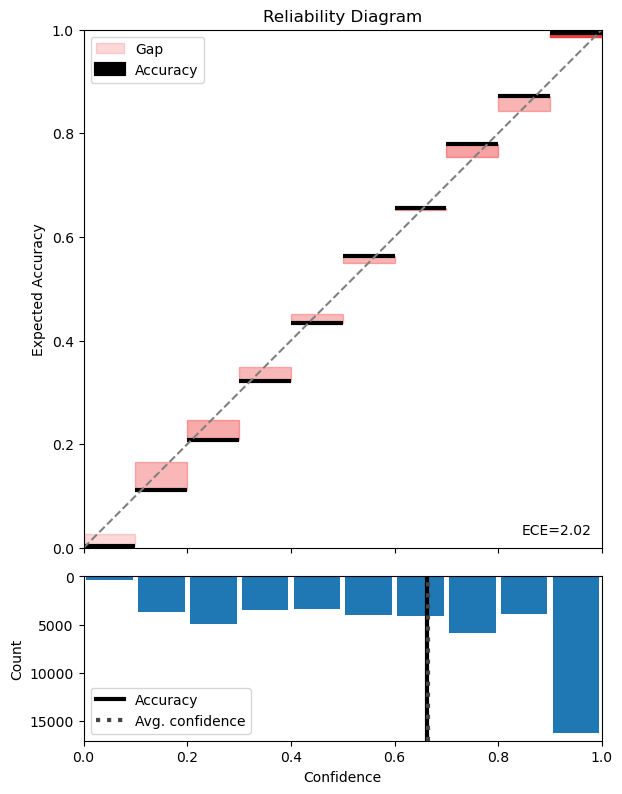

In [233]:
title = "Reliability Diagram"

ones = np.ones(len(df_out.true_label))

fig = reliability_diagram(df_out.true_label, ones, df_out.confidence, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title=title, figsize=(6, 6), dpi=100, 
                          return_fig=True)

/tmp/ipykernel_118270/2298429955.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


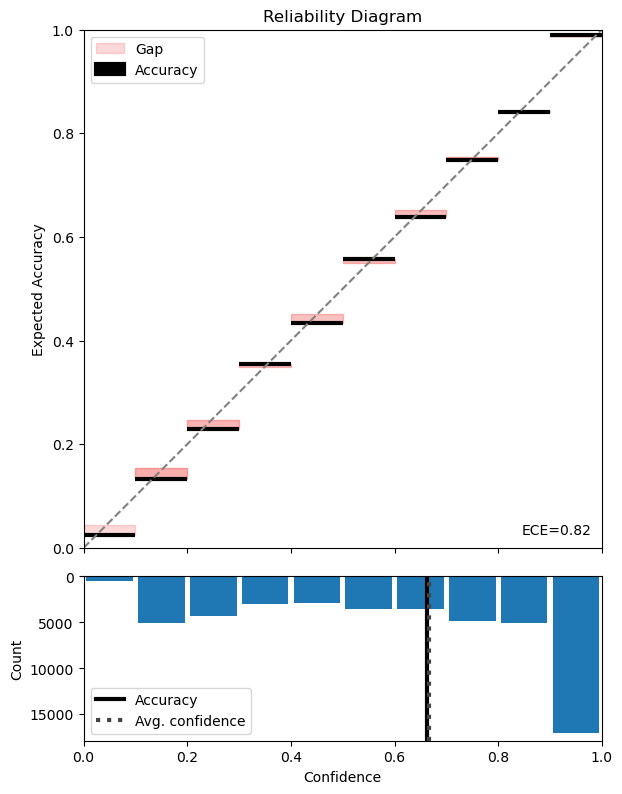

In [234]:
title = "Reliability Diagram"

fig = reliability_diagram(df_out.true_label, ones, df_out.temp_scaled, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title=title, figsize=(6, 6), dpi=100, 
                          return_fig=True)

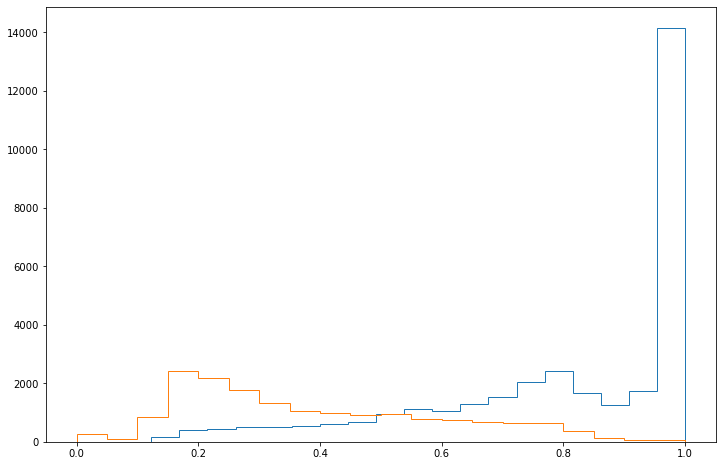

In [218]:
plt.figure(figsize = (12,8))

yes = norm_preds[y_train == 1].numpy()
no = norm_preds[y_train == 0].numpy()

plt.hist(yes, bins = 20, histtype = "step");
plt.hist(no, bins = 20, histtype = "step");

In [235]:
"""
Using this code for the calibration plot, will create our own from this later
https://github.com/hollance/reliability-diagrams
"""


import os
import numpy as np
import matplotlib.pyplot as plt


def compute_calibration(true_labels, pred_labels, confidences, num_bins=10):
    """Collects predictions into bins used to draw a reliability diagram.
    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
    The true_labels, pred_labels, confidences arguments must be NumPy arrays;
    pred_labels and true_labels may contain numeric or string labels.
    For a multi-class model, the predicted label and confidence should be those
    of the highest scoring class.
    Returns a dictionary containing the following NumPy arrays:
        accuracies: the average accuracy for each bin
        confidences: the average confidence for each bin
        counts: the number of examples in each bin
        bins: the confidence thresholds for each bin
        avg_accuracy: the accuracy over the entire test set
        avg_confidence: the average confidence over the entire test set
        expected_calibration_error: a weighted average of all calibration gaps
        max_calibration_error: the largest calibration gap across all bins
    """
    assert(len(confidences) == len(pred_labels))
    assert(len(confidences) == len(true_labels))
    assert(num_bins > 0)

    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    indices = np.digitize(confidences, bins, right=True)

    bin_accuracies = np.zeros(num_bins, dtype=np.float)
    bin_confidences = np.zeros(num_bins, dtype=np.float)
    bin_counts = np.zeros(num_bins, dtype=np.int)

    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_accuracies[b] = np.mean(true_labels[selected] == pred_labels[selected])
            bin_confidences[b] = np.mean(confidences[selected])
            bin_counts[b] = len(selected)

    avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
    avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

    gaps = np.abs(bin_accuracies - bin_confidences)
    ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
    mce = np.max(gaps)

    return { "accuracies": bin_accuracies, 
             "confidences": bin_confidences, 
             "counts": bin_counts, 
             "bins": bins,
             "avg_accuracy": avg_acc,
             "avg_confidence": avg_conf,
             "expected_calibration_error": ece,
             "max_calibration_error": mce }


def _reliability_diagram_subplot(ax, bin_data, 
                                 draw_ece=True, 
                                 draw_bin_importance=False,
                                 title="Reliability Diagram", 
                                 xlabel="Confidence", 
                                 ylabel="Expected Accuracy"):
    """Draws a reliability diagram into a subplot."""
    accuracies = bin_data["accuracies"]
    confidences = bin_data["confidences"]
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    widths = bin_size
    alphas = 0.3
    min_count = np.min(counts)
    max_count = np.max(counts)
    normalized_counts = (counts - min_count) / (max_count - min_count)

    if draw_bin_importance == "alpha":
        alphas = 0.2 + 0.8*normalized_counts
    elif draw_bin_importance == "width":
        widths = 0.1*bin_size + 0.9*bin_size*normalized_counts

    colors = np.zeros((len(counts), 4))
    colors[:, 0] = 240 / 255.
    colors[:, 1] = 60 / 255.
    colors[:, 2] = 60 / 255.
    colors[:, 3] = alphas

    gap_plt = ax.bar(positions, np.abs(accuracies - confidences), 
                     bottom=np.minimum(accuracies, confidences), width=widths,
                     edgecolor=colors, color=colors, linewidth=1, label="Gap")

    acc_plt = ax.bar(positions, 0, bottom=accuracies, width=widths,
                     edgecolor="black", color="black", alpha=1.0, linewidth=3,
                     label="Accuracy")

    ax.set_aspect("equal")
    ax.plot([0,1], [0,1], linestyle = "--", color="gray")
    
    if draw_ece:
        ece = (bin_data["expected_calibration_error"] * 100)
        ax.text(0.98, 0.02, "ECE=%.2f" % ece, color="black", 
                ha="right", va="bottom", transform=ax.transAxes)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #ax.set_xticks(bins)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.legend(handles=[gap_plt, acc_plt])


def _confidence_histogram_subplot(ax, bin_data, 
                                  draw_averages=True,
                                  title="Examples per bin", 
                                  xlabel="Confidence",
                                  ylabel="Count"):
    """Draws a confidence histogram into a subplot."""
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    ax.bar(positions, counts, width=bin_size * 0.9)
   
    ax.set_xlim(0, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if draw_averages:
        acc_plt = ax.axvline(x=bin_data["avg_accuracy"], ls="solid", lw=3, 
                             c="black", label="Accuracy")
        conf_plt = ax.axvline(x=bin_data["avg_confidence"], ls="dotted", lw=3, 
                              c="#444", label="Avg. confidence")
        ax.legend(handles=[acc_plt, conf_plt])


def _reliability_diagram_combined(bin_data, 
                                  draw_ece, draw_bin_importance, draw_averages, 
                                  title, figsize, dpi, return_fig):
    """Draws a reliability diagram and confidence histogram using the output
    from compute_calibration()."""
    figsize = (figsize[0], figsize[0] * 1.4)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize, dpi=dpi, 
                           gridspec_kw={"height_ratios": [4, 1]})

    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.1)

    _reliability_diagram_subplot(ax[0], bin_data, draw_ece, draw_bin_importance, 
                                 title=title, xlabel="")

    # Draw the confidence histogram upside down.
    orig_counts = bin_data["counts"]
    bin_data["counts"] = -bin_data["counts"]
    _confidence_histogram_subplot(ax[1], bin_data, draw_averages, title="")
    bin_data["counts"] = orig_counts

    # Also negate the ticks for the upside-down histogram.
    new_ticks = np.abs(ax[1].get_yticks()).astype(np.int)
    ax[1].set_yticklabels(new_ticks)    

    plt.show()

    if return_fig: return fig


def reliability_diagram(true_labels, pred_labels, confidences, num_bins=10,
                        draw_ece=True, draw_bin_importance=False, 
                        draw_averages=True, title="Reliability Diagram", 
                        figsize=(6, 6), dpi=72, return_fig=False):
    """Draws a reliability diagram and confidence histogram in a single plot.
    
    First, the model's predictions are divided up into bins based on their
    confidence scores.
    The reliability diagram shows the gap between average accuracy and average 
    confidence in each bin. These are the red bars.
    The black line is the accuracy, the other end of the bar is the confidence.
    Ideally, there is no gap and the black line is on the dotted diagonal.
    In that case, the model is properly calibrated and we can interpret the
    confidence scores as probabilities.
    The confidence histogram visualizes how many examples are in each bin. 
    This is useful for judging how much each bin contributes to the calibration
    error.
    The confidence histogram also shows the overall accuracy and confidence. 
    The closer these two lines are together, the better the calibration.
    
    The ECE or Expected Calibration Error is a summary statistic that gives the
    difference in expectation between confidence and accuracy. In other words,
    it's a weighted average of the gaps across all bins. A lower ECE is better.
    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        draw_averages: whether to draw the overall accuracy and confidence in
            the confidence histogram
        title: optional title for the plot
        figsize: setting for matplotlib; height is ignored
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    bin_data = compute_calibration(true_labels, pred_labels, confidences, num_bins)
    return _reliability_diagram_combined(bin_data, draw_ece, draw_bin_importance,
                                         draw_averages, title, figsize=figsize, 
                                         dpi=dpi, return_fig=return_fig)


def reliability_diagrams(results, num_bins=10,
                         draw_ece=True, draw_bin_importance=False, 
                         num_cols=4, dpi=72, return_fig=False):
    """Draws reliability diagrams for one or more models.
    
    Arguments:
        results: dictionary where the key is the model name and the value is
            a dictionary containing the true labels, predicated labels, and
            confidences for this model
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        num_cols: how wide to make the plot
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    ncols = num_cols
    nrows = (len(results) + ncols - 1) // ncols
    figsize = (ncols * 4, nrows * 4)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, 
                           figsize=figsize, dpi=dpi, constrained_layout=True)

    for i, (plot_name, data) in enumerate(results.items()):
        y_true = data["true_labels"]
        y_pred = data["pred_labels"]
        y_conf = data["confidences"]
        
        bin_data = compute_calibration(y_true, y_pred, y_conf, num_bins)
        
        row = i // ncols
        col = i % ncols
        _reliability_diagram_subplot(ax[row, col], bin_data, draw_ece, 
                                     draw_bin_importance, 
                                     title="\n".join(plot_name.split()),
                                     xlabel="Confidence" if row == nrows - 1 else "",
                                     ylabel="Expected Accuracy" if col == 0 else "")

    for i in range(i + 1, nrows * ncols):
        row = i // ncols
        col = i % ncols        
        ax[row, col].axis("off")
        
    plt.show()

    if return_fig: return fig


